In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch
import ast

In [2]:
df = pd.read_csv("data_wyscout/pl17_18_shots.csv")

In [3]:
df["loc_x"] = df.positions.apply(lambda x: (100 - ast.literal_eval(x)[0]["x"])* (105/100)) #100 - x = distance to goal. it helps to calc goal dist
df["loc_y"] = df.positions.apply(lambda x: ast.literal_eval(x)[0]["y"] * 68/100)
df["c"] = df.positions.apply(lambda x: abs(ast.literal_eval(x)[0]["y"] - 50) * 68/100) #distance to the center of the goal (50)

df["dist"] = df.apply(lambda x: np.sqrt(x["loc_x"]**2 + x["c"]**2), axis=1) #pytaghoras


In [4]:
def calculate_angle(x, y, w = 7.32):
    up = w*x
    bottom = x**2 + y**2 - (w/2)**2
    
    tan_ang = up/bottom
    
    ang = np.arctan(tan_ang)
    if ang <= 0:
        ang = ang+np.pi
    
    return ang

In [5]:
df["angle"] = df.apply(lambda x: calculate_angle(x["loc_x"], x["c"]), axis=1)

In [6]:
df["Goal"] = df.tags.apply(lambda x: 1 if True in [True if (i["id"] == 101) else False for i in ast.literal_eval(x)] else 0)

In [7]:
headers = df[df.tags.apply(lambda x: True in [True if (i["id"] == 403) else False for i in ast.literal_eval(x)])]

In [33]:
shots = df.drop(headers.index)

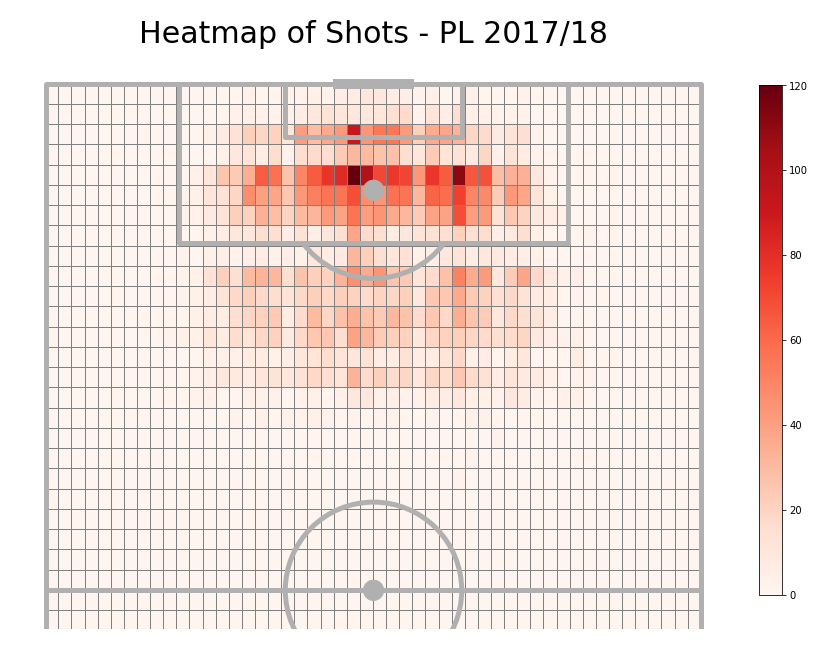

In [9]:
pitch = VerticalPitch(linewidth=5, spot_scale=0.01, half=True, pitch_type = "custom", pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

bin_statistic = pitch.bin_statistic(105-df.loc_x, df.loc_y, statistic='count', bins=50)

pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'], linewidth=0.01)

ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))
cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle("Heatmap of Shots - PL 2017/18", fontsize = 30)
plt.show()

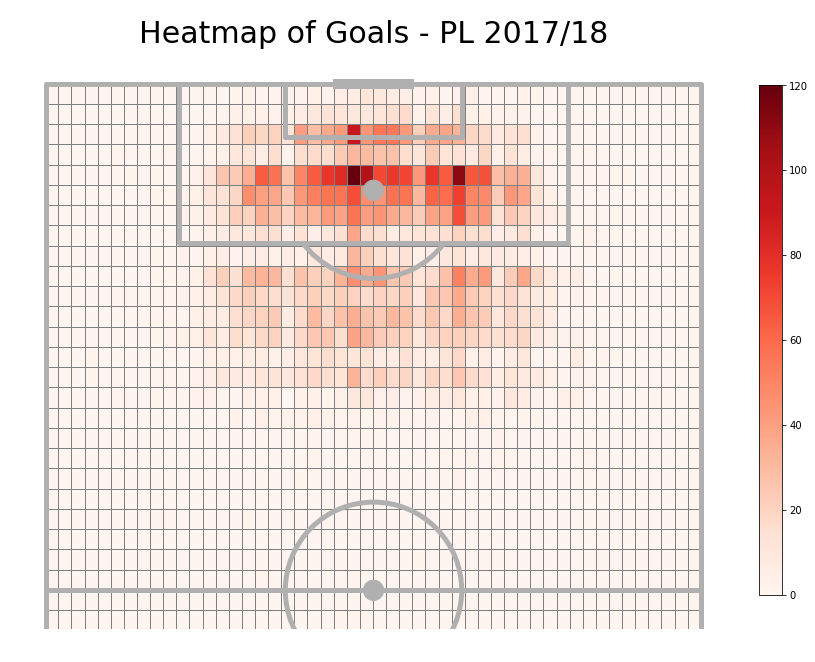

In [10]:
pitch = VerticalPitch(linewidth=5, spot_scale=0.01, half=True, pitch_type = "custom", pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

goals = df[df["Goal"] == "Goal"]

bin_statistic_goals = pitch.bin_statistic(105-goals.loc_x, goals.loc_y, statistic='count', bins=50)

pcm  = pitch.heatmap(bin_statistic, cmap='Reds', edgecolor='grey', ax=ax['pitch'], linewidth=0.01)
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))

cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle("Heatmap of Goals - PL 2017/18", fontsize = 30)
plt.show()

In [11]:
bin_statistic_prob = bin_statistic
bin_statistic_prob["statistic"] = bin_statistic_goals["statistic"]/bin_statistic["statistic"]
bin_statistic_prob["statistic"][np.isnan(bin_statistic_prob["statistic"])] = 0
#bin_statistic_prob_dict = {"statistic": bin_statistic_prob}

/home/sergio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


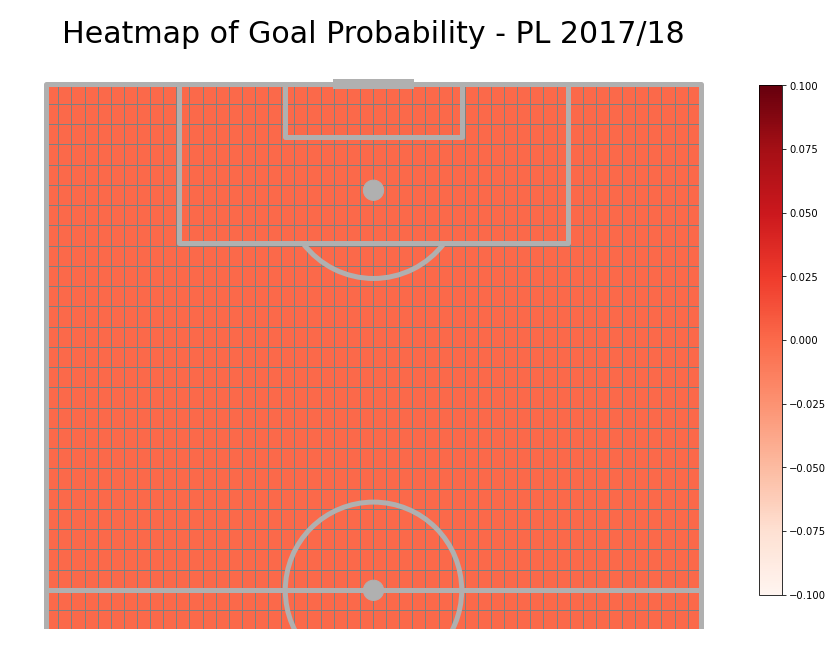

In [12]:
pitch = VerticalPitch(linewidth=5, spot_scale=0.01, half=True, pitch_type = "custom", pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

goals = df[df["Goal"] == "Goal"]

#bin_statistic = pitch.bin_statistic(105-goals.loc_x, goals.loc_y, statistic='count', bins=50)

pcm  = pitch.heatmap(bin_statistic_prob, cmap='Reds', edgecolor='grey', ax=ax['pitch'], linewidth=0.01)
ax_cbar = fig.add_axes((1, 0.093, 0.03, 0.786))

cbar = plt.colorbar(pcm, cax=ax_cbar)
fig.suptitle("Heatmap of Goal Probability - PL 2017/18", fontsize = 30)
plt.show()

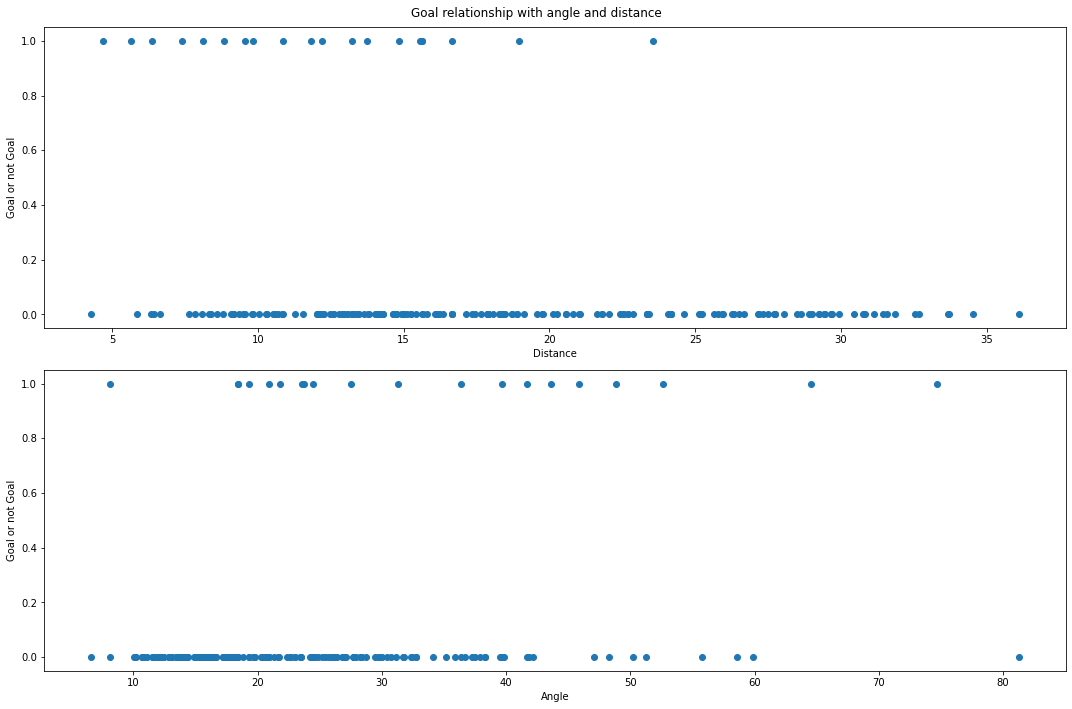

In [13]:
subset_anl = df.sample(200)

fig, ax = plt.subplots(2, figsize=(15, 10))
ax[0].scatter(x = subset_anl["dist"], y=subset_anl["Goal"])

ax[0].set_ylabel("Goal or not Goal")
ax[0].set_xlabel("Distance")

ax[1].scatter(x = subset_anl["angle"]*180/np.pi, y=subset_anl["Goal"])

ax[1].set_ylabel("Goal or not Goal")
ax[1].set_xlabel("Angle")
fig.suptitle("Goal relationship with angle and distance")

fig.tight_layout()
plt.show()

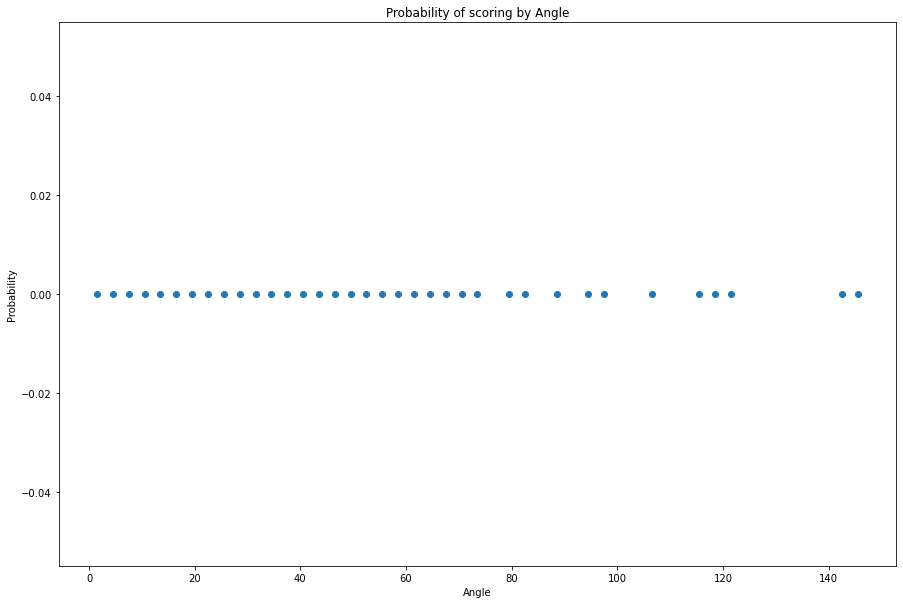

In [14]:
shots_bin = np.histogram((df["angle"]*180/np.pi), bins=50, range=[0, 150])
goals_bin = np.histogram((goals["angle"]*180/np.pi), bins=50, range=[0, 150])

np.seterr(divide='ignore', invalid='ignore')

probs_bin = shots_bin
probs_bin = np.divide(goals_bin[0], shots_bin[0])
#probs_bin[np.isnan(probs_bin)] = 0


#THE [1] ARRAY OF SHOTS_BIN AND GOALS_BIN REPRESENTS THE HISTOGRAM INTERVALS
#BETWEEN 0 ANGLE AND 3 ANGLE THERE ARE X SHOTS THAT WENT GOAL, FOR EXAMPLE
#SO, WE NEED TO USE THE MIDDLE VALUE OF THE INTERVAL AS A REPRESENTATION.
midangle = (shots_bin[1][:-1] + shots_bin[1][1:])/2


plt.figure(figsize=(15, 10))
plt.scatter(midangle, probs_bin)
plt.title("Probability of scoring by Angle")
plt.xlabel("Angle")
plt.ylabel("Probability")
plt.show()

In [15]:
x = df[["angle"]]

y = df["Goal"]#.apply(lambda x: 1 if x == "Goal" else 0)

In [16]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression()

log_reg.fit(x, y)

LogisticRegression()

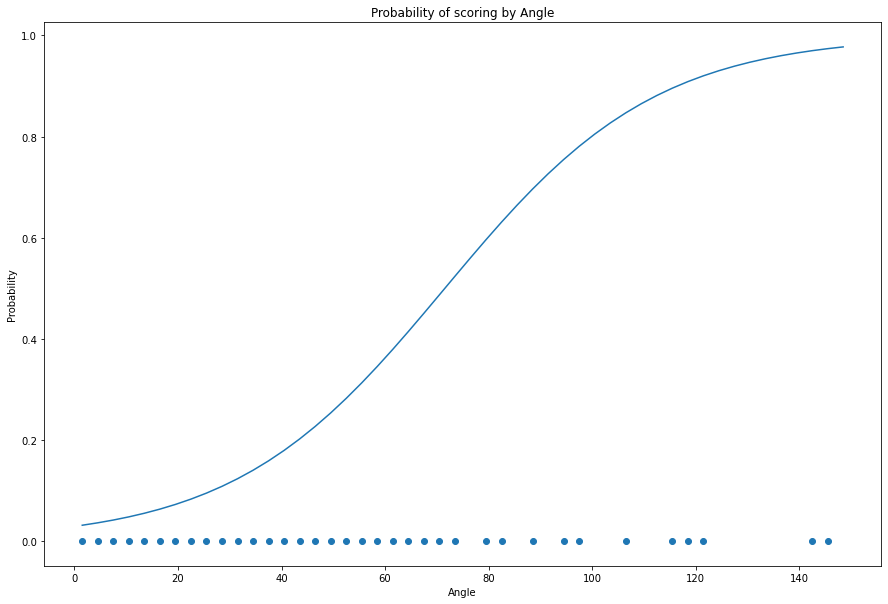

In [17]:
pred_ang = []

pred_values = log_reg.predict_proba((midangle.reshape(-1, 1) * np.pi)/180)[:, 1:].reshape(1, -1)[0]

plt.figure(figsize=(15, 10))
plt.scatter(midangle, probs_bin)
plt.plot(midangle, pred_values)
plt.title("Probability of scoring by Angle")
plt.xlabel("Angle")
plt.ylabel("Probability")
plt.show()

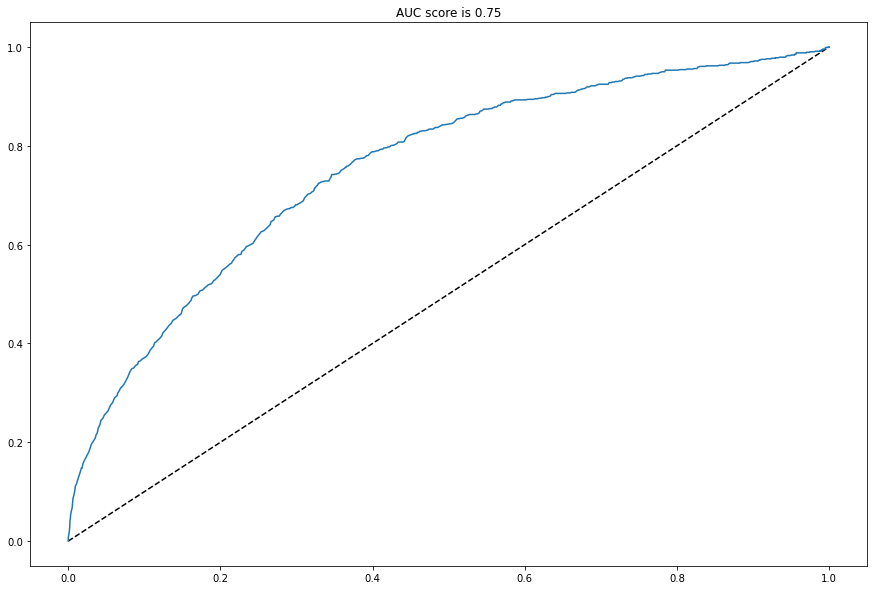

In [18]:
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, _ = roc_curve(y, log_reg.predict_proba(x.values)[:,1]) #test AUC
plt.figure(figsize=(15,10))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)

auc = roc_auc_score(y, log_reg.predict_proba(x)[:,1])
plt.title('AUC score is %.2f'%(auc))
plt.show()

In [19]:
#trying different models:
#dist model
x_dist = df[["dist"]]

dist_lr = LogisticRegression()

dist_lr.fit(x_dist, y)




LogisticRegression()

In [20]:
#dist and angle
from sklearn.preprocessing import StandardScaler

X_da = df[["dist", "angle"]]

scaler = StandardScaler()
X_da_sc = scaler.fit_transform(X_da)

da_lr = LogisticRegression()

da_lr.fit(X_da_sc, y)

LogisticRegression()

In [21]:
#polynomial dist and angle model
da_poly_df = pd.DataFrame()

da_poly_df["Goal"] = y
da_poly_df["Angle_sq"] = df["angle"]**2
da_poly_df["Dist_sq"] = df["dist"] **2
da_poly_df["Dist_Angle"] = df["dist"]*df["angle"]

X_da_poly = da_poly_df[["Angle_sq", "Dist_Angle", "Dist_sq"]]

scaler_da_poly = StandardScaler()
X_da_poly_sc = scaler_da_poly.fit_transform(X_da)

da_poly_lr = LogisticRegression()
da_poly_lr.fit(X_da_poly_sc, y)

LogisticRegression()

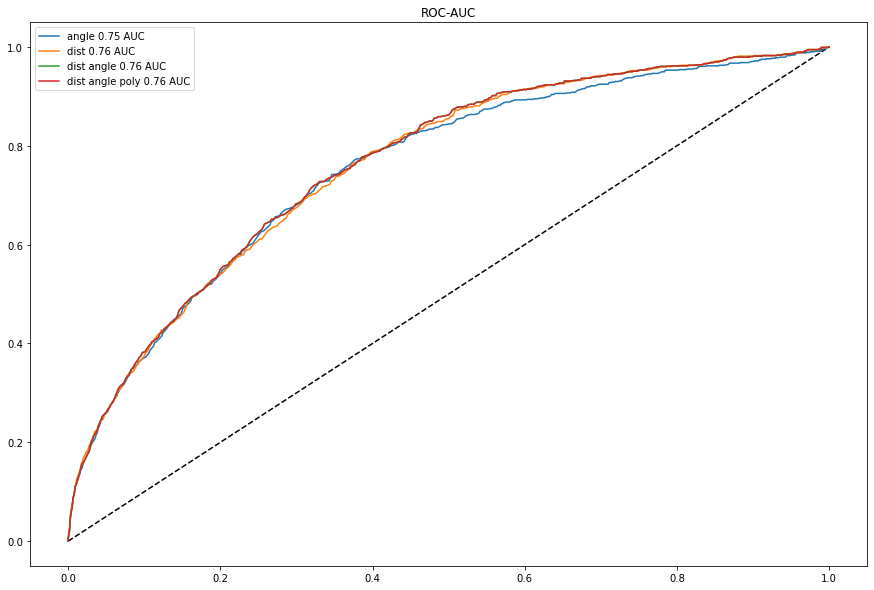

In [22]:
fig, ax = plt.subplots(figsize=(15,10))

fpr, tpr, _ = roc_curve(y, log_reg.predict_proba(x.values)[:,1]) #test AUC
auc = roc_auc_score(y, log_reg.predict_proba(x)[:,1])
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr, label=("angle %.2f AUC"%(auc)))

fpr, tpr, _ = roc_curve(y, dist_lr.predict_proba(x_dist.values)[:,1]) #test AUC
auc = roc_auc_score(y, dist_lr.predict_proba(x_dist.values)[:,1])
ax.plot(fpr, tpr, label=("dist %.2f AUC"%(auc)))

fpr, tpr, _ = roc_curve(y, da_lr.predict_proba(X_da_sc)[:,1]) #test AUC
auc = roc_auc_score(y, da_lr.predict_proba(X_da_sc)[:,1])
ax.plot(fpr, tpr, label=("dist angle %.2f AUC"%(auc)))

fpr, tpr, _ = roc_curve(y, da_poly_lr.predict_proba(X_da_poly_sc)[:,1]) #test AUC
auc = roc_auc_score(y, da_poly_lr.predict_proba(X_da_poly_sc)[:,1])
ax.plot(fpr, tpr, label=("dist angle poly %.2f AUC"%(auc)))


plt.legend()
plt.title('ROC-AUC')
plt.show()

In [23]:
df["xG"] = da_lr.predict_proba(X_da_sc)[:,1]

In [24]:
#df["Goal_n"] = df["Goal"].apply(lambda x: 1 if x == "Goal" else 0)
df.groupby("shortName").sum()[["Goal", "xG"]].sort_values("Goal", ascending=False).head(15)

,Goal,xG
shortName,,
Mohamed Salah,31,15.114526
H. Kane,27,21.148002
R. Sterling,17,11.934234
S. Ag\u00fcero,17,12.176501
R. Lukaku,16,12.508296
J. Vardy,15,8.533014
Roberto Firmino,14,7.899974
Gabriel Jesus,13,9.421610
A. Lacazette,12,8.697382


In [25]:
df.groupby("officialName").sum()[["Goal", "xG"]].sort_values("xG", ascending=False).head(15)

,Goal,xG
officialName,,
Manchester City FC,94,66.579165
Liverpool FC,78,62.176884
Tottenham Hotspur FC,67,58.435114
Arsenal FC,69,56.752165
Chelsea FC,55,53.558235
Manchester United FC,64,52.920597
Crystal Palace FC,35,47.517351
Watford FC,39,44.433540
Southampton FC,32,44.159699


In [26]:
hk = df[df["shortName"] == "H. Kane"]

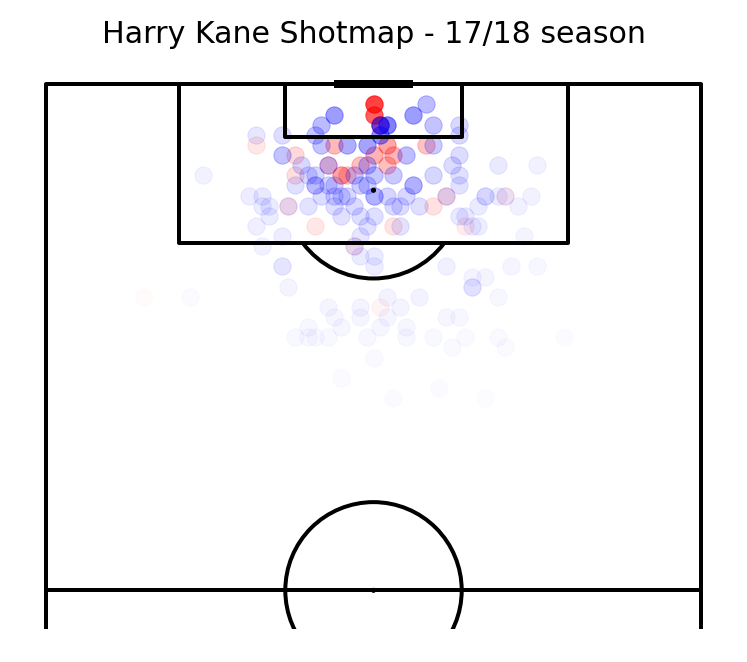

In [27]:
pitch = VerticalPitch(line_color='black', linewidth = 4, half=True, pitch_type = "custom", pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

for i, row in hk[hk["Goal"] == 1].iterrows():
    pitch.scatter(105 - row.loc_x, row.loc_y, alpha = row.xG, s = 300, color = "red", ax=ax['pitch']) 

for i, row in hk[hk["Goal"] == 0].iterrows():
    #alpha = row[row["Goal"] == "Not Goal"].xG
    pitch.scatter(105 - row.loc_x, row.loc_y, alpha = row.xG, s = 300, color = "blue", ax=ax['pitch'])
    

fig.suptitle("Harry Kane Shotmap - 17/18 season", fontsize=30)    
plt.show()

In [28]:
plus_10 = df[df.shortName.isin(df.shortName.value_counts()[df.shortName.value_counts() > 10].index.values)]

In [29]:
plus_10.groupby("shortName").mean()[["Goal", "xG"]].sort_values("Goal", ascending=False).head(10)

,Goal,xG
shortName,,
P. Aubameyang,0.346154,0.184655
C. Smalling,0.333333,0.238531
L. Depoitre,0.300000,0.164620
J. Hern\u00e1ndez,0.296296,0.178524
C. Tosun,0.277778,0.181591
C. Wood,0.263158,0.192392
Bernardo Silva,0.260870,0.117811
J. Lascelles,0.250000,0.198739
S. Mustafi,0.250000,0.133187


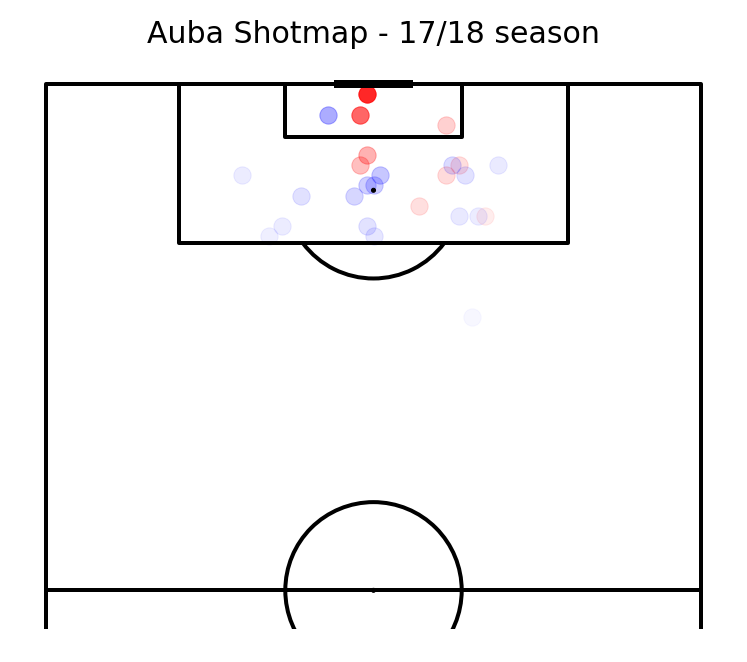

In [30]:
auba = plus_10[plus_10["shortName"] == "P. Aubameyang"]
pitch = VerticalPitch(line_color='black', linewidth = 4, half=True, pitch_type = "custom", pitch_length=105, pitch_width=68, line_zorder = 2)
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)

for i, row in auba[auba["Goal"] == 1].iterrows():
    pitch.scatter(105 - row.loc_x, row.loc_y, alpha = row.xG, s = 300, color = "red", ax=ax['pitch']) 

for i, row in auba[auba["Goal"] == 0].iterrows():
    #alpha = row[row["Goal"] == "Not Goal"].xG
    pitch.scatter(105 - row.loc_x, row.loc_y, alpha = row.xG, s = 300, color = "blue", ax=ax['pitch'])
    

fig.suptitle("Auba Shotmap - 17/18 season", fontsize=30)    
plt.show()

In [31]:
shotsimport pickle
pickle.dump(da_lr, open("models/xg_model.pkl", 'wb'))

In [34]:
#dist and angle
from sklearn.preprocessing import StandardScaler

y_shots = shots["Goal"]#.apply(lambda x: 1 if x == "Goal" else 0)
X_da_shots = shots[["dist", "angle"]]

scaler_shots = StandardScaler()
X_da_sc_shots = scaler_shots.fit_transform(X_da_shots)

da_lr_shots = LogisticRegression()

da_lr_shots.fit(X_da_sc_shots, y_shots)

LogisticRegression()

In [35]:
#dist and angle
from sklearn.preprocessing import StandardScaler

y_headers = headers["Goal"]#.apply(lambda x: 1 if x == "Goal" else 0)
X_da_headers = headers[["dist", "angle"]]

scaler_headers = StandardScaler()
X_da_sc_headers = scaler_headers.fit_transform(X_da_headers)

da_lr_headers = LogisticRegression()

da_lr_headers.fit(X_da_sc_headers, y_headers)

LogisticRegression()

In [36]:
shots["xG"] = da_lr_shots.predict_proba(X_da_sc_shots)[:,1]

In [37]:
shots

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,...,officialName_home,officialName_away,shortName,loc_x,loc_y,c,dist,angle,Goal,xG
0,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 41, 'x': 88}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,94.595788,...,Arsenal FC,Leicester City FC,A. Lacazette,12.60,27.88,6.12,14.007655,0.467241,1,0.137504
1,10,Shot,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",25413,"[{'y': 48, 'x': 87}, {'y': 0, 'x': 0}]",2499719,Shot,1609,1H,2813.844402,...,Arsenal FC,Leicester City FC,A. Lacazette,13.65,32.64,1.36,13.717584,0.519343,0,0.149831
2,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1207}, {'id'...",25413,"[{'y': 34, 'x': 90}, {'y': 0, 'x': 0}]",2499719,Shot,1609,2H,2354.807116,...,Arsenal FC,Leicester City FC,A. Lacazette,10.50,23.12,10.88,15.120331,0.342993,0,0.106835
3,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1212}, {'id'...",25413,"[{'y': 33, 'x': 90}, {'y': 100, 'x': 100}]",2499743,Shot,1609,2H,1404.650587,...,Arsenal FC,Liverpool FC,A. Lacazette,10.50,22.44,11.56,15.616773,0.321870,0,0.099076
4,10,Shot,"[{'id': 101}, {'id': 402}, {'id': 201}, {'id':...",25413,"[{'y': 58, 'x': 82}, {'y': 0, 'x': 0}]",2499749,Shot,1609,1H,1616.714627,...,Arsenal FC,AFC Bournemouth,A. Lacazette,18.90,39.44,5.44,19.667323,0.354820,1,0.067279
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8445,10,Shot,"[{'id': 401}, {'id': 201}, {'id': 1214}, {'id'...",20450,"[{'y': 24, 'x': 88}, {'y': 100, 'x': 100}]",2499723,Shot,1639,1H,2091.065818,...,Everton FC,Stoke City FC,Bojan,12.60,16.32,17.68,21.710421,0.198745,0,0.044613
8446,10,Shot,"[{'id': 402}, {'id': 1212}, {'id': 1802}]",8624,"[{'y': 55, 'x': 87}, {'y': 100, 'x': 100}]",2499946,Shot,1623,1H,2369.342944,...,Everton FC,Tottenham Hotspur FC,J. McCarthy,13.65,37.40,3.40,14.067071,0.496371,0,0.141180
8447,10,Shot,"[{'id': 402}, {'id': 201}, {'id': 1205}, {'id'...",7928,"[{'y': 42, 'x': 96}, {'y': 100, 'x': 100}]",2499983,Shot,1611,2H,2939.073129,...,Newcastle United FC,Manchester United FC,M. Carrick,4.20,28.56,5.44,6.872671,0.737527,0,0.338270
8448,10,Shot,"[{'id': 402}, {'id': 2101}, {'id': 1802}]",7928,"[{'y': 41, 'x': 76}, {'y': 0, 'x': 0}]",2500093,Shot,1611,2H,61.766427,...,Watford FC,Manchester United FC,M. Carrick,25.20,27.88,6.12,25.932497,0.272891,0,0.030695


In [38]:
#shots["Goal_n"] = shots["Goal"]#.apply(lambda x: 1 if x == "Goal" else 0)
shots.groupby("shortName").sum()[["Goal", "xG"]].sort_values("Goal", ascending=False).head(15)

,Goal,xG
shortName,,
Mohamed Salah,29,16.655327
H. Kane,21,18.394768
R. Sterling,17,14.140541
R. Lukaku,13,11.188625
J. Vardy,12,8.387484
S. Ag\u00fcero,12,10.846411
M. Arnautovi\u0107,11,9.352104
A. Lacazette,11,9.834071
Roberto Firmino,11,6.207807


In [39]:
headers["xG"] = da_lr_headers.predict_proba(X_da_sc_headers)[:,1]

#headers["Goal_n"] = headers["Goal"].apply(lambda x: 1 if x == "Goal" else 0)
headers.groupby("shortName").sum()[["Goal", "xG"]].sort_values("Goal", ascending=False).head(15)

/home/sergio/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Goal,xG
shortName,,
\u00c1lvaro Morata,7,3.282214
H. Kane,6,3.619711
S. Ag\u00fcero,5,1.928606
S. Mouni\u00e9,4,1.818100
O. Giroud,4,2.168894
C. Wood,3,2.703904
R. Lukaku,3,2.160697
P. Crouch,3,1.607805
Gabriel Jesus,3,1.453295


In [40]:
import pickle
pickle.dump(da_lr_shots, open("models/xg_shots.pkl", 'wb'))
pickle.dump(da_lr_headers, open("models/xg_headers.pkl", 'wb'))
pickle.dump(scaler_shots, open("models/sc_shots.pkl", 'wb'))
pickle.dump(scaler_headers, open("models/sc_headers.pkl", 'wb'))